# Sentiment Analysis of Drug Reviews using LSTM
This notebook builds an LSTM model to classify drug reviews as either positive or negative.


## Import Libraries
Import all the necessary libraries for data processing, modeling, and visualization.


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
import os
import pandas as pd
import numpy as np
import re

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.utils import resample
import gc


## Download NLTK Resources
We need to download necessary NLTK data like stopwords and tokenizer.


In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mikes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\mikes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Device
Set device to GPU if available

In [6]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(is_cuda)

True


##Early Stopping
Define early stopping so we can put 100 epochs in the training loop and avoid overfitting

In [7]:
# Early stopping class to prevent overfitting
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

## Load and Preprocess Data
Load the training and test datasets, and preprocess them by cleaning text and balancing classes.


In [8]:
# Load the data
def get_train_test():
    cwd = os.getcwd()
    train_path = cwd + "\data\drugsComTrain_raw.tsv"
    test_path = cwd + "\data\drugsComTest_raw.tsv"
    if os.path.exists(train_path) and os.path.exists(test_path):
        df_train = pd.read_csv(train_path, sep='\t')
        df_test = pd.read_csv(test_path, sep='\t')
        return df_train, df_test
    else:
        print(f"Error: Train file or test file not found in the specified path.")
        print(f"Expected Train Path: {train_path}")
        print(f"Expected Test Path: {test_path}")
        return None, None

def balance_class(df):
    # Separate majority and minority classes
    positive = df[df['rating'] == 1]
    negative = df[df['rating'] == 0]

    print(df['rating'].value_counts())

    # Perform random oversampling for the minority class
    negative_oversampled = resample(negative,
                                    replace=True,     # Sample with replacement
                                    n_samples=len(positive),  # Match number in majority class
                                    random_state=42)  # For reproducibility

    # Combine the oversampled minority class with the majority class
    comb_balanced = pd.concat([positive, negative_oversampled])
    print(comb_balanced['rating'].value_counts())
    return comb_balanced

# Remove common stop words from test
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split() 
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def clean_text(text):
    # Implementation for text cleaning
    cleaned_text = str(text).lower()
    # Remove punctuation
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespace
    cleaned_text = re.sub(r"\s+", '', cleaned_text)
    # Remove digits
    cleaned_text = re.sub(r"\d", '', cleaned_text)
    return cleaned_text

# Assuming you have your dataframe loaded as df
def create_vocabulary(texts, max_vocab_size=10000):
    word_counts = Counter()
    for text in texts:
        words = str(text).lower().split()
        word_counts.update(words)

    # Keep most common words
    vocab = ['<pad>', '<unk>'] + [word for word, count in word_counts.most_common(max_vocab_size-2)]
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    return word2idx

# Custom collate function for DataLoader to pad sequences
def collate_fn(batch):
    reviews = [torch.tensor(item['review'], dtype=torch.long) for item in batch]
    ratings = torch.tensor([item['rating'] for item in batch], dtype=torch.float)

    padded_reviews = rnn_utils.pad_sequence(reviews, batch_first=True, padding_value=0)
    return {
        'review': padded_reviews,
        'rating': ratings
    }

# Training function
def train_model(model, train_loader, valid_loader, criterion, optimizer, n_epochs, device):
    early_stopping = EarlyStopping(patience=3)

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0

        for batch in train_loader:
            reviews = batch['review'].to(device)
            ratings = batch['rating'].to(device)

            optimizer.zero_grad()
            outputs = model(reviews).squeeze()
            loss = criterion(outputs, ratings)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            total_train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_correct += (predicted == ratings).sum().item()
            train_total += ratings.size(0)

        # Validation phase
        model.eval()
        total_valid_loss = 0
        valid_correct = 0
        valid_total = 0

        with torch.no_grad():
            for batch in valid_loader:
                reviews = batch['review'].to(device)
                ratings = batch['rating'].to(device)

                outputs = model(reviews).squeeze()
                loss = criterion(outputs, ratings)

                total_valid_loss += loss.item()
                predicted = (outputs > 0.5).float()
                valid_correct += (predicted == ratings).sum().item()
                valid_total += ratings.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        avg_valid_loss = total_valid_loss / len(valid_loader)
        train_acc = train_correct / train_total * 100
        valid_acc = valid_correct / valid_total * 100

        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_acc:.2f}%')

        # Early stopping
        early_stopping(avg_valid_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    return model

## LSTM Model Definition
Define the LSTM model that will be used for sentiment classification.

In [9]:
# Define your LSTMSentiment model
class LSTMSentiment(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128, n_layers=1, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            bidirectional=True, dropout=dropout if n_layers > 1 else 0, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        output = torch.mean(output, dim=1)
        output = self.batch_norm(output)
        output = self.dropout(output)
        return self.fc(output)

In [10]:
# Dataset class to hold the reviews and ratings
class DrugReviewDataset(Dataset):
    def __init__(self, reviews, ratings):
        self.reviews = reviews
        self.ratings = ratings

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return {
            'review': torch.tensor(self.reviews[idx], dtype=torch.long),
            'rating': torch.tensor(self.ratings[idx], dtype=torch.float)
        }

## Data Cleaning & Vocabulary Creation
Define functions to clean the text data by removing punctuation, digits, and other unnecessary characters.

We create a vocabulary of the most frequently used words in the dataset.


In [11]:
# Load csv files
df_train, df_test = get_train_test()

# Ensure files loaded successfully
if df_train is not None and df_test is not None:
    print("Data loaded successfully.")
else:
    print("Data loading failed. Please check the file paths.")

# Create corpus from training data
if df_train is not None:
     # Check column names
    print(df_train.columns)
    print(df_test.columns)

    # Ratings greater than 7 are positive, other are not positive
    df_train['rating'] = df_train['rating'].apply(lambda x: 1 if x > 7 else 0).values
    df_test['rating'] = df_test['rating'].apply(lambda x: 1 if x > 7 else 0).values

    # Resample minority class to ensure equal distribution
    df_train = balance_class(df_train)
    df_test = balance_class(df_test)

    # Set y for train and test
    y_train = df_train['rating'].values
    y_test = df_test['rating'].values

    # Ensure mean is 0.5 for balanced class
    print(f"y_train.mean()={y_train.mean():.5f}")
    print(f"y_test.mean()={y_test.mean():.5f}")

    # Lower case the review
    df_train['processed_review'] = df_train['review'].apply(lambda x: str(x).lower())
    df_test['processed_review'] = df_test['review'].apply(lambda x: str(x).lower())
  
    # Remove stop words
    df_train['processed_review'] = df_train['processed_review'].apply(remove_stopwords)
    df_test['processed_review'] = df_test['processed_review'].apply(remove_stopwords)

    # Create vocabulary
    word2idx = create_vocabulary(df_train['processed_review'])

    # Create vecorized word list for Train and Test
    word_list_train = []
    for line in df_train['processed_review']:
        line_tokens = [word2idx.get(word, word2idx['<unk>']) for word in line.split()]
        word_list_train.append(line_tokens)
    
    word_list_test = []
    for line in df_test['processed_review']:
        line_tokens = [word2idx.get(word, word2idx['<unk>']) for word in line.split()]
        word_list_test.append(line_tokens)

Data loaded successfully.
Index(['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')
Index(['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')
rating
1    97410
0    63887
Name: count, dtype: int64
rating
1    97410
0    97410
Name: count, dtype: int64
rating
1    32349
0    21417
Name: count, dtype: int64
rating
1    32349
0    32349
Name: count, dtype: int64
y_train.mean()=0.50000
y_test.mean()=0.50000


## Training the LSTM Model
Train the LSTM model using the training dataset and validate it.

In [12]:
# Ensure that the length of reviews and labels match
assert len(word_list_train) == len(y_train), "Training reviews and labels are not of the same length."

# Split into training and validation sets
word_list_train, word_list_valid, y_train, y_valid = train_test_split(word_list_train, y_train, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = DrugReviewDataset(word_list_train, y_train)
valid_dataset = DrugReviewDataset(word_list_valid, y_valid)
test_dataset = DrugReviewDataset(word_list_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Define model hyper-parameters
model = LSTMSentiment(
    vocab_size=len(word2idx),
    embedding_dim=100,
    hidden_dim=128,
    n_layers=5,
    dropout=0.5
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.BCEWithLogitsLoss()

# Train the model
model1 = train_model(model, train_loader, valid_loader, criterion, optimizer, n_epochs=100, device=device)

# Cleanup
gc.collect()
torch.cuda.empty_cache()
del model
del optimizer

C:\Users\mikes\AppData\Local\Temp\ipykernel_31476\2785465290.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reviews = [torch.tensor(item['review'], dtype=torch.long) for item in batch]


Epoch 1:
Train Loss: 0.5790 | Train Acc: 66.81%
Valid Loss: 0.5265 | Valid Acc: 71.81%
Epoch 2:
Train Loss: 0.4904 | Train Acc: 74.85%
Valid Loss: 0.4367 | Valid Acc: 78.41%
Epoch 3:
Train Loss: 0.4533 | Train Acc: 77.65%
Valid Loss: 0.4128 | Valid Acc: 80.55%
Epoch 4:
Train Loss: 0.4253 | Train Acc: 79.43%
Valid Loss: 0.4015 | Valid Acc: 81.04%
Epoch 5:
Train Loss: 0.4061 | Train Acc: 80.68%
Valid Loss: 0.3798 | Valid Acc: 82.73%
Epoch 6:
Train Loss: 0.3884 | Train Acc: 81.84%
Valid Loss: 0.3708 | Valid Acc: 83.56%
Epoch 7:
Train Loss: 0.3722 | Train Acc: 82.91%
Valid Loss: 0.3676 | Valid Acc: 83.97%
Epoch 8:
Train Loss: 0.3583 | Train Acc: 83.59%
Valid Loss: 0.3573 | Valid Acc: 85.25%
Epoch 9:
Train Loss: 0.3452 | Train Acc: 84.37%
Valid Loss: 0.3438 | Valid Acc: 85.74%
Epoch 10:
Train Loss: 0.3327 | Train Acc: 85.11%
Valid Loss: 0.3477 | Valid Acc: 86.33%
Epoch 11:
Train Loss: 0.3216 | Train Acc: 85.64%
Valid Loss: 0.3245 | Valid Acc: 86.96%
Epoch 12:
Train Loss: 0.3101 | Train Acc:

## Model Evaluation and Results
Evaluate the model's performance and visualize test accuracy and loss.

C:\Users\mikes\AppData\Local\Temp\ipykernel_31476\2785465290.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reviews = [torch.tensor(item['review'], dtype=torch.long) for item in batch]


test_correct=56385 test_total=64698
Percent correct in test 87.15%
precision=0.8587 recall=0.8894 f1=0.8738 auc=0.8715


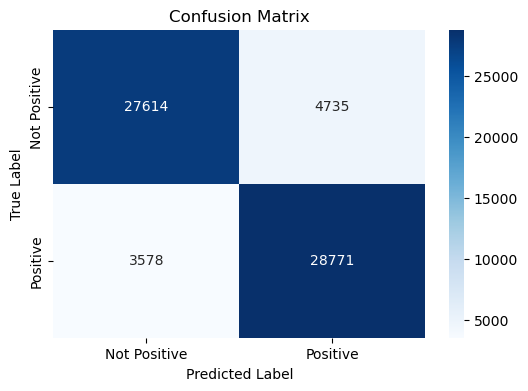

In [15]:
total_test_loss = 0
test_correct = 0
test_total = 0
y_pred = []

# Loop over test dataloader
with torch.no_grad():
    for batch in test_loader:
        reviews = batch['review'].to(device)
        ratings = batch['rating'].to(device)

        # Get prediction
        outputs = model1(reviews).squeeze()
        
        # Calculate loss
        loss = criterion(outputs, ratings)
        total_test_loss += loss.item()

        # Get predicted value
        predicted = (outputs > 0.5).float()

        # Create y_pred to store all predictions
        y_pred = y_pred + predicted.tolist()
        test_correct += (predicted == ratings).sum().item()
        test_total += ratings.size(0)

print(f"test_correct={test_correct} test_total={test_total}")

# Validate prediction accuracy using Pandas
df_result = pd.DataFrame()
df_result['y_test'] = y_test
df_result['y_pred'] = y_pred
df_result['correct'] = np.where(df_result['y_test'] == df_result['y_pred'], 1, 0)

print(f"Percent correct in test {df_result['correct'].mean()*100:.2f}%")

precision = precision_score(y_test, y_pred) 
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(f"precision={precision:.4f} recall={recall:.4f} f1={f1:.4f} auc={auc:.4f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(df_result['y_test'], df_result['y_pred'])

# Optionally, you can plot the confusion matrix for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Positive', 'Positive'], yticklabels=['Not Positive', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Conclusion
The LSTM model was successfully trained on drug review sentiment data, achieving reasonable accuracy. Future work could involve experimenting with different architectures and tuning hyperparameters for improved results.
